In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from nbodyUtil import util

## Reconstruction Function

In [2]:
def reconstructPhase(sv, tau, n, density=1):
    '''
    reconstructPhase()
        samples state vector 'sv' at delay tau, with dimension n
    '''
    state = []
    for _ in range(n): state.append([])
    
    for i in range(0, len(sv)-(n*tau), density):
        for dim in range(n):
            state[dim].append(sv[i+(dim*tau)])
            
    return state

## n-body Problem

Much of the code for this is taken from a project I did for Phys115

Modeling the mechanics of planetary systems is, in simple cases, rather straight-forward. In considering large enough scales such that general relativity and tidal effects are minimal, one can model interactions between planets, stars and planetary satellites using only Newtonian gravity.

\begin{gather*}
F^{(g)} = - \frac{GMm}{r^2}
\end{gather*}

where $m$ and $M$ are the masses of the bodies and $r$ is the distance between them. 

We can combine this with Newton's second law and come up with an equation of motion:
$$\begin{align*}
F &= ma \\
F &= m\ddot{x} \\
- \frac{GMm}{r^2} &= m\ddot{x} \\
\ddot{x} &= - \frac{GM}{r^2}
\end{align*}$$

To handle things numerically, we break the above relation into $\hat{x}$ and $\hat{y}$ directions, representing the horizontal and vertical directions on a plane.

\begin{align}
\ddot{x} &= -GM \frac{x}{(x^2 + y^2)^{3/2}} &
\ddot{x} &= -GM \frac{y}{(x^2 + y^2)^{3/2}} \\
\end{align}

Generalizing the above equations to suit $n$ bodies is straightforward as well. 
\begin{gather*}
\ddot{x} = - \sum_i^n GM_i \frac{x-x_i}{[(x-x_i)^2 + (y-y_i)^2]^{3/2}}
\end{gather*}

Where $x$ and $y$ refer to the location of the body feeling the force, and $x_i$ and $y_i$ refer to locations of bodies exerting the force. In future sections, I refer to the body feeling a force as a "receiver" and bodies responsible for the force on the receiver as "sources". 

By choosing units such that $GM=1$, we can then define each smaller mass as a fraction of $M$, and not worry about units of kilograms. The above equation for acceleration of a receiver with multiple sources can then be slightly simplified by ignoring $G$.

To create a linear system, we define:
$$
y_1 = x \\
y_2 = \dot{x}
$$
then our derivative are:
$$
\begin{cases} 
      \dot{y}_1 = \dot{x} \\
      \dot{y}_2 = \ddot{x} = - \sum_i^n GM_i \frac{x-x_i}{[(x-x_i)^2 + (y-y_i)^2]^{3/2}} \\
   \end{cases}
$$

### Programmatically

The code for the nbody system is implemented in the `nbodyUtil.py` file. There are a few equations that are important:

* `getBin()`: Returns initial conditions for a stable binary. A stellar binary is used here because planets orbiting binaries generally have chaotic and often unstable orbits
* `nbody()`: This function handles the derivatives for the system. Essentially the math derived above is implemented here.

It's also worth mentioning that the state vector here will be $4\times n$ where $n$ is the number of bodies present. The state vector will be in the order $(x, y, v_x, v_y)$ for each body. 

In [3]:
Ms, Y0 = util.getBin()

mp = 5e-6

xp  = 2.55
yp  = 0.0
vxp = 0.0
vyp = 1.0 # above 1.0 is unstable for starting position (2.55, 0)

Ms = Ms + [mp]
Y0 = Y0 + [xp,yp,vxp,vyp]

T = 10000
t = np.linspace(1,T,T*50)

Y = scipy.integrate.odeint(util.nbody, Y0, t, args=(Ms,))
# state vector follows form (x, y, vx, vy)

Text(0, 0.5, 'y')

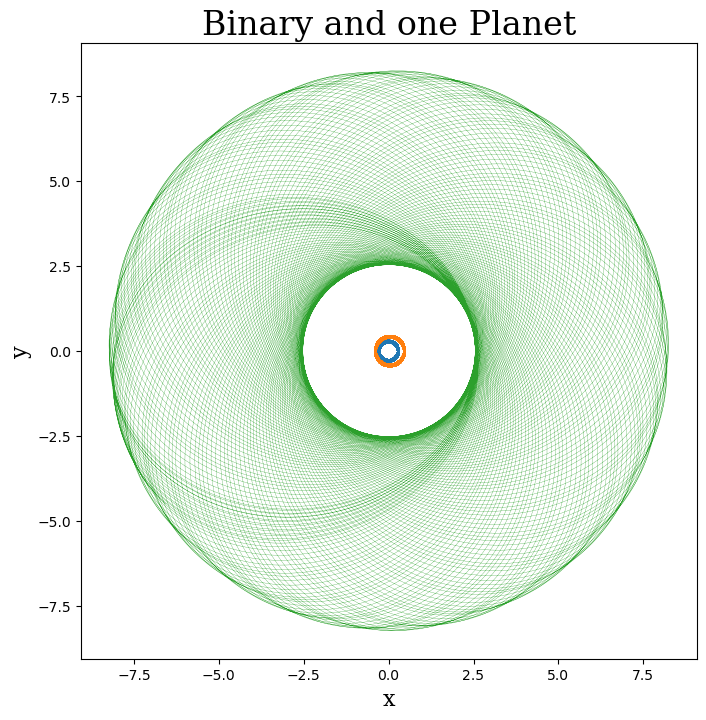

In [4]:
%matplotlib inline

fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.set_aspect(1.0)

ax.scatter(Y[:,0],Y[:,1],s=0.1)
ax.scatter(Y[:,4],Y[:,5],s=0.1)
ax.plot(Y[:,8],Y[:,9],linewidth=0.2, c='tab:green')

majorM = (Y[:,0].max() - Y[:,0].min())/2
minorM = (Y[:,1].max() - Y[:,0].min())/2

majorm = (Y[:,4].max() - Y[:,4].min())/2
minorm = (Y[:,5].max() - Y[:,5].min())/2

# prettify
ax.set_title('Binary and one Planet', fontfamily='serif', fontsize=24)
ax.set_xlabel('x', fontfamily='serif', fontsize=16)
ax.set_ylabel('y', fontfamily='serif', fontsize=16)

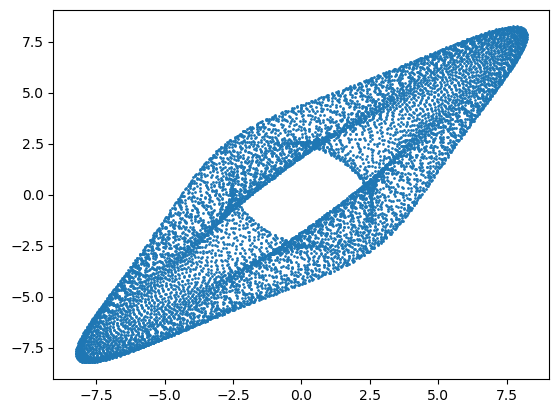

In [5]:
%matplotlib inline
# Let's reconstruct the phase
tau = 300
n = 3

# there's a lot of data here, so for quicker plotting let's use a fraction of it
xp = Y[:,8]
yp = Y[:,9]
vxp= Y[:,10]
vyp= Y[:,11]

sxp = reconstructPhase(xp, tau, n, density=50)
syp = reconstructPhase(yp, tau, n, density=50)
svxp= reconstructPhase(vxp, tau, n, density=50)
svyp= reconstructPhase(vyp, tau, n, density=50)

data = sxp

plt.scatter(data[0], data[1], s=1)

Text(0.5, 0.92, '3D Reconstruction')

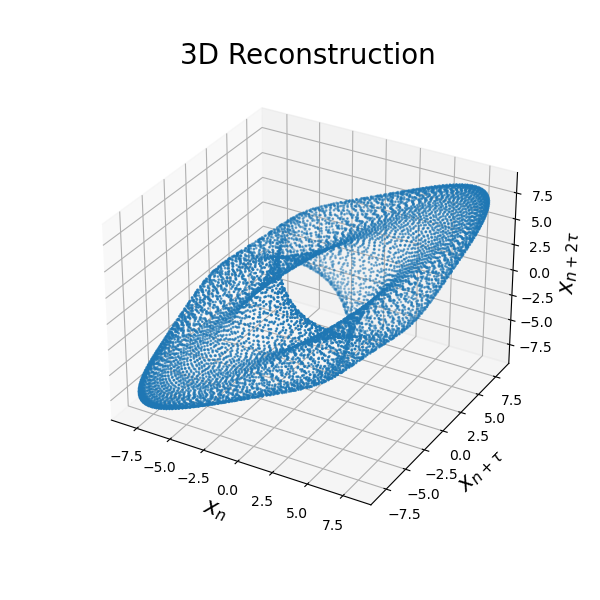

In [75]:
%matplotlib widget

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0], data[1], data[2], s=1)

ax.set_xlabel(r'$x_n$', fontsize=16)
ax.set_ylabel(r'$x_{n+\tau}$', fontsize=16)
ax.set_zlabel(r'$x_{n+2\tau}$', fontsize=16)

ax.set_title('3D Reconstruction', fontsize=20)